# =============================
# Script 3: fine_tune_TCGA.py
# =============================

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from torch.optim import lr_scheduler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.manifold import TSNE

from mlp import MLP
from evaluation import Evaluation
from utils import DATA_MODALITIES, RAW_BOTH_DATA_FOLDER, BOTH_SCREENING_DATA_FOLDER, CCLE_RAW_DATA_FOLDER, CCLE_SCREENING_DATA_FOLDER, TCGA_DATA_FOLDER, TCGA_SCREENING_DATA
from data_loader_pretraining import RawDataLoader
from pretrain_autoencoders import SimpleAutoencoder
from train_mlp_on_latent import DeepDRA_pretrained

# Utiliser le GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu
cpu
cpu
cpu


Reading Raw Data Files...:   0%|                                                                 | 0/4 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  50%|████████████████████████████▌                            | 2/4 [00:02<00:02,  1.47s/it]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:160: FutureWarning

tcga_data when loaded: dict_keys(['cell_exp', 'cell_mut', 'drug_desc', 'drug_finger'])
cell_exp: (664, 17737)
cell_mut: (664, 15009)
drug_desc: (32, 209)
drug_finger: (32, 4048)
Preparing data...
sensitive train data len: 573
resistance train data len: 377
x_cell_tcga shape: (950, 30879)
x_drug_tcga shape: (950, 4257)
Distribution des classes : Counter({np.float64(0.0): 377, np.float64(1.0): 377})
Taille du set de fine-tuning (train_len): 10
Taille du set de validation (test_len): 744


C:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 - Fine-tune train Loss: 12.2428, Fine-tune Validation Loss: 8.4862 
Epoch 2 - Fine-tune train Loss: 12.1898, Fine-tune Validation Loss: 6.9542 
Epoch 3 - Fine-tune train Loss: 3.5970, Fine-tune Validation Loss: 6.1732 
Epoch 4 - Fine-tune train Loss: 3.6972, Fine-tune Validation Loss: 5.7128 
Epoch 5 - Fine-tune train Loss: 3.7593, Fine-tune Validation Loss: 5.5712 
Epoch 6 - Fine-tune train Loss: 3.5868, Fine-tune Validation Loss: 5.4368 
Epoch 7 - Fine-tune train Loss: 3.2015, Fine-tune Validation Loss: 5.3138 
Epoch 8 - Fine-tune train Loss: 3.3139, Fine-tune Validation Loss: 5.2010 
Epoch 9 - Fine-tune train Loss: 2.9810, Fine-tune Validation Loss: 5.0950 
Epoch 10 - Fine-tune train Loss: 2.5807, Fine-tune Validation Loss: 4.9930 
Epoch 11 - Fine-tune train Loss: 3.0678, Fine-tune Validation Loss: 4.8901 
Epoch 12 - Fine-tune train Loss: 3.0682, Fine-tune Validation Loss: 4.7915 
Epoch 13 - Fine-tune train Loss: 2.7771, Fine-tune Validation Loss: 4.6963 
Epoch 14 - Fine-tun

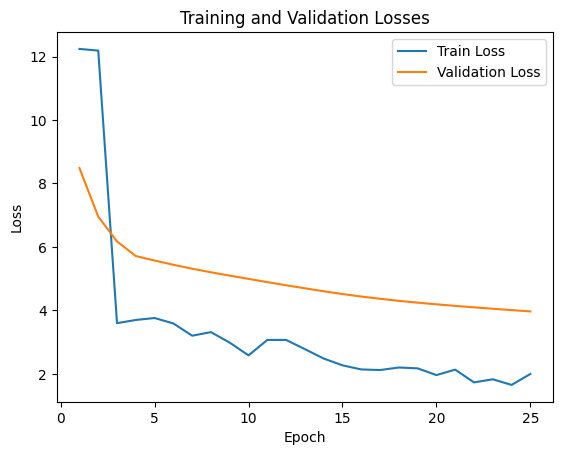

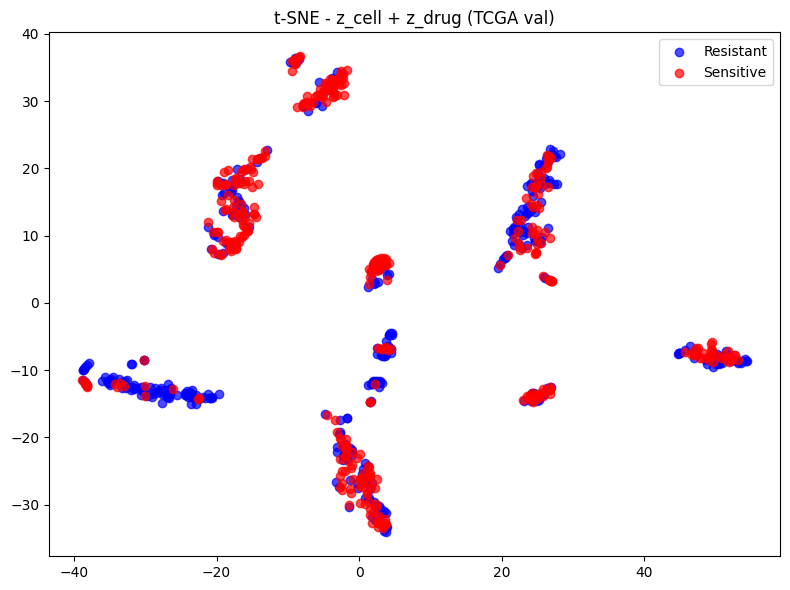

Final Results:
AVG: Accuracy: 0.473, Precision: 0.473, Recall: 0.462, F1 score: 0.467, AUC: 0.523, ,AUPRC: 0.511
 Average AUC: 0.523 	 Average AUPRC: 0.511 	 Std AUPRC: 0.000


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def fine_tune_TCGA(run_id=0):
    set_seed(42)

    cell_ae_latent_dim = 700
    drug_ae_latent_dim = 50
    
    # Initialisation de l'historique des métriques
    history = {'AUC': [], 'AUPRC': [], "Accuracy": [], "Precision": [], "Recall": [], "F1 score": []}

    # Load pre-trained models
    encoder_cell = torch.load(f"encoder_cell_trained_run_{run_id}.pt", weights_only=False).to(device)
    encoder_drug = torch.load(f"encoder_drug_trained_run_{run_id}.pt", weights_only=False).to(device)
    
    mlp = MLP(cell_ae_latent_dim + drug_ae_latent_dim, 1)
    mlp.load_state_dict(torch.load(f"mlp_trained_run_{run_id}.pth"))
    mlp = mlp.to(device)
    
    # Load TCGA data
    tcga_data, tcga_screen = RawDataLoader.load_data(
        data_modalities=DATA_MODALITIES,
        raw_file_directory=TCGA_DATA_FOLDER,
        screen_file_directory=TCGA_SCREENING_DATA,
        sep="\t")
    
    print('tcga_data when loaded:', tcga_data.keys())
    for key, df in tcga_data.items():
        print(f"{key}: {df.shape}")

    import pickle
    
    with open("feature_columns.pkl", "rb") as f:
        all_features = pickle.load(f)

    for key in ['cell_exp', 'cell_mut', 'drug_desc', 'drug_finger']:   # to modify depending on the modalities used for pretraining
        tcga_data[key] = tcga_data[key].reindex(columns=all_features[key], fill_value=0.0)
    

    x_cell_tcga, x_drug_tcga, y_tcga, cell_sizes, drug_sizes = RawDataLoader.prepare_input_data(tcga_data, tcga_screen)

    print('x_cell_tcga shape:', x_cell_tcga.shape)
    print('x_drug_tcga shape:', x_drug_tcga.shape)

    # Application d'un sous-échantillonnage pour équilibrer la classe majoritaire    
    rus = RandomUnderSampler(sampling_strategy="majority", random_state=42)
    dataset = pd.concat([x_cell_tcga, x_drug_tcga], axis=1)
    dataset.index = x_cell_tcga.index
    dataset, y_tcga = rus.fit_resample(dataset, y_tcga)
    x_cell_tcga = dataset.iloc[:, :sum(cell_sizes)]
    x_drug_tcga = dataset.iloc[:, sum(cell_sizes):]

    from collections import Counter
    print("Distribution des classes :", Counter(y_tcga))
    
    # Convert into PyTorch tensors
    x_cell_tensor = torch.Tensor(x_cell_tcga.values).to(device)
    x_drug_tensor = torch.Tensor(x_drug_tcga.values).to(device)
    y_tensor = torch.Tensor(y_tcga).unsqueeze(1).to(device)
    
    x_cell_tensor = torch.nn.functional.normalize(x_cell_tensor, dim=0)
    x_drug_tensor = torch.nn.functional.normalize(x_drug_tensor, dim=0)
    
    dataset = TensorDataset(x_cell_tensor, x_drug_tensor, y_tensor)

    train_len = int(0.0145 * len(dataset))     # Modify here the number of samples used for fine-tuning
    test_len = len(dataset) - train_len

    print(f"Taille du set de fine-tuning (train_len): {train_len}")
    print(f"Taille du set de validation (test_len): {test_len}")
    
    generator = torch.Generator().manual_seed(42)
    train_dataset, test_dataset = random_split(dataset, [train_len, test_len], generator=generator)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=torch.Generator().manual_seed(42))
    val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Préparer le fine-tuning
    
    encoder_cell.train()
    encoder_drug.train()
    mlp.train()
    
    # Optional : Freeze if fine-tuning only for MLP
    # for param in encoder_cell.parameters(): param.requires_grad = False
    # for param in encoder_drug.parameters(): param.requires_grad = False
    
    ae_optimizer = optim.Adam(
        list(encoder_cell.parameters()) + list(encoder_drug.parameters()),
        lr=1e-4,
        weight_decay=1e-8
    )
    mlp_optimizer = optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=1e-8)
    scheduler = lr_scheduler.ReduceLROnPlateau(mlp_optimizer, mode='min', factor=0.8, patience=5, verbose=True)
    
    criterion = nn.BCELoss()

    # Fine-tuning
    
    epochs = 25
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        encoder_cell.train()
        encoder_drug.train()
        mlp.train()
        
        total_loss = 0
        for Xc, Xd, yt in train_loader:
            Xc, Xd, yt = Xc.to(device), Xd.to(device), yt.to(device)
            ae_optimizer.zero_grad()
            mlp_optimizer.zero_grad()
            
            z_cell = encoder_cell(Xc)
            z_drug = encoder_drug(Xd)
            z = torch.cat([z_cell, z_drug], dim=1)
            
            y_pred = mlp(z)
            loss = criterion(y_pred, yt)
            loss.backward()
            ae_optimizer.step()
            mlp_optimizer.step()
            total_loss += loss.item()
    
        avg_loss = total_loss / len(train_loader)
    
        # Validation
        encoder_cell.eval()
        encoder_drug.eval()
        mlp.eval()

        val_loss = 0
        y_true_all = []
        y_pred_all = []
    
        with torch.no_grad():
            for Xc_val, Xd_val, yt_val in val_loader:
                Xc_val, Xd_val = Xc_val.to(device), Xd_val.to(device)
                zc_val = encoder_cell(Xc_val)
                zd_val = encoder_drug(Xd_val)
                z_val = torch.cat([zc_val, zd_val], dim=1)
                y_pred_val = mlp(z_val)
                val_loss += criterion(y_pred_val, yt_val.to(device)).item()
            
                y_true_all.append(yt_val.cpu())
                y_pred_all.append(y_pred_val.cpu())
                
        val_loss /= len(val_loader)
    
        scheduler.step(val_loss)
        
        train_losses.append(avg_loss)
        val_losses.append(val_loss)
    
        print(f"Epoch {epoch+1} - Fine-tune train Loss: {avg_loss:.4f}, Fine-tune Validation Loss: {val_loss:.4f} ")

    # Plot losses and accuracies
    Evaluation.plot_train_val_loss(train_losses, val_losses, epochs)

    y_true = torch.cat(y_true_all).numpy()
    y_pred = torch.cat(y_pred_all).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)

    current_result = {
        "Accuracy": accuracy_score(y_true, y_pred_label),
        "Precision": precision_score(y_true, y_pred_label, zero_division=0),
        "Recall": recall_score(y_true, y_pred_label),
        "F1 score": f1_score(y_true, y_pred_label),
        "AUC": roc_auc_score(y_true, y_pred),
        "AUPRC": average_precision_score(y_true, y_pred)
    }
    
    history = Evaluation.add_results(history, current_result)

    # Sauvegarde des modèles fine-tunés

    torch.save(encoder_cell, f"encoder_cell_finetuned_on_TCGA_run.pt")
    torch.save(encoder_drug, f"encoder_drug_finetuned_on_TCGA_run.pt")

    torch.save(mlp.state_dict(), f"mlp_finetuned_on_TCGA_run.pth")
    
    # Concaténation des features latents pour t-SNE
    z_all = []
    y_all = []

    with torch.no_grad():
        for Xc_val, Xd_val, yt_val in val_loader:
            Xc_val, Xd_val = Xc_val.to(device), Xd_val.to(device)
            zc_val = encoder_cell(Xc_val)
            zd_val = encoder_drug(Xd_val)
            z_concat = torch.cat([zc_val, zd_val], dim=1)

            z_all.append(z_concat.cpu())
            y_all.append(yt_val.cpu())

    z_all = torch.cat(z_all)
    y_all = torch.cat(y_all)

    # t-SNE plot

    def plot_tsne(z_tensor, y_tensor, title):
        z_embedded = TSNE(n_components=2, random_state=42).fit_transform(z_tensor.numpy())
        y_np = y_tensor.numpy().ravel()
        plt.figure(figsize=(8, 6))
        for label, color in zip([0, 1], ['blue', 'red']):
            plt.scatter(z_embedded[y_np == label, 0], z_embedded[y_np == label, 1],
                        label='Resistant' if label == 0 else 'Sensitive',
                        c=color, alpha=0.7)
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_tsne(z_all, y_all, "t-SNE - z_cell + z_drug (TCGA val)")

    return history


if __name__ == "__main__":
    history = fine_tune_TCGA(run_id=0)
    Evaluation.show_final_results(history)